In [1]:
!pip install -q kaggle
from google.colab import files
#Hier kaggle.json übergeben
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oledziewas","key":"87e93a05787af3b987a4a69d4ab09dd6"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle competitions download -c ofu-xai-projb-2023-life-of-dl-engineer-new
! unzip /content/ofu-xai-projb-2023-life-of-dl-engineer-new.zip > /dev/null

 87% 89.0M/103M [00:01<00:00, 50.1MB/s]
100% 103M/103M [00:01<00:00, 59.9MB/s] 


In [4]:
import os
from PIL import Image
import numpy as np
import csv
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

In [5]:
! mkdir streetnumbers

In [6]:
data_augment_count = 16
# Create Lables
with open('/content/StreetNumbers/StreetNumbers/labels_train.csv', 'r') as file:
    # create a CSV reader object
    csv_reader = csv.reader(file)
     # skip the header row
    next(csv_reader, None)
    # get the second column using list comprehension
    column_2 = [int(row[1]) for row in csv_reader]
    digits = np.array(column_2)
    labels = np.eye(9)[digits-1]

labels = np.tile(labels, (data_augment_count+1, 1))
print(len(labels))
# Split Data
train_labels = labels[:(470*data_augment_count)]
test_labels = labels[(470*data_augment_count):]

# Save Data
np.save('/content/streetnumbers/train_labels.npy', train_labels)
np.save('/content/streetnumbers/test_labels.npy', test_labels)

9690


In [ ]:
# Benutzerdefinierte Funktion zur Hinzufügung von Rauschen
def add_noise(image):
    # Konvertiere das PIL-Bild in einen Tensor
    image_tensor = transforms.ToTensor()(image)
    noise_factor = random.uniform(0,0.1)
    # Erzeuge Rauschen
    noise_tensor = torch.randn_like(image_tensor) * noise_factor  # Hier kannst du die Stärke des Rauschens anpassen
    #Addiere das Rauschen zum Bild
    noisy_image_tensor = image_tensor + noise_tensor
    # Begrenze die Werte auf den gültigen Bereich von 0 bis 1
    noisy_image_tensor = torch.clamp(noisy_image_tensor, 0, 1)
    # Konvertiere den Tensor zurück in ein PIL-Bild
    noisy_image = transforms.ToPILImage()(noisy_image_tensor)
    return noisy_image

transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop((256, 256)),
    transforms.Lambda(lambda img: add_noise(img))
])

# Create Inputs
data_dir_train = '/content/StreetNumbers/StreetNumbers/train'
data_dir_validation = '/content/StreetNumbers/StreetNumbers/test'
def create_np_arrays(dir, validation_dataset = False):
  cnt = 0
  # Create an empty list to hold the image tensors
  image_arrays = []
  directories = sorted(os.listdir(dir))
  # Iterate over the image files in the data directory
  for filename in directories:
      if filename.endswith('.png'):
          # Load the image file and apply the transformation
          with Image.open(os.path.join(dir, filename)) as img:
            img = img.convert('RGB')
          img_array = np.array(img)
          img_array = img_array.flatten()
          # Normalize the pixel values to lie in [-1, 1] [0, 255] -> [0, 1]
          img_array = img_array.astype('float32') / 255.0
          image_arrays.append(img_array)

  if (validation_dataset):
    return image_arrays

  for i in range(data_augment_count):
    for filename in directories:
        if filename.endswith('.png'):
            # Load the image file and apply the transformation
            with Image.open(os.path.join(dir, filename)) as img:
              img = img.convert('RGB')
            augmented_image = transform(img)
            augmented_array = np.array(augmented_image)
            augmented_array = augmented_array.flatten()
            # Normalize the pixel values to lie in [-1, 1] [0, 255] -> [0, 1]
            augmented_array = augmented_array.astype('float32') / 255.0
            image_arrays.append(augmented_array)

  train_inputs = image_arrays[:(470*data_augment_count)]
  test_inputs = image_arrays[(470*data_augment_count):]
  return train_inputs, test_inputs

train_inputs, test_inputs = create_np_arrays(data_dir_train)
validation_inputs = create_np_arrays(data_dir_validation, validation_dataset = True)

# Save Data
np.save('/content/streetnumbers/train_inputs.npy', train_inputs)
np.save('/content/streetnumbers/test_inputs.npy', test_inputs)
np.save('/content/streetnumbers/validation_inputs.npy', validation_inputs)

In [ ]:
!rm /content/streetnumbers/*

rm: cannot remove '/content/streetnumbers/test': Is a directory
rm: cannot remove '/content/streetnumbers/train': Is a directory
rm: cannot remove '/content/streetnumbers/validation': Is a directory


276


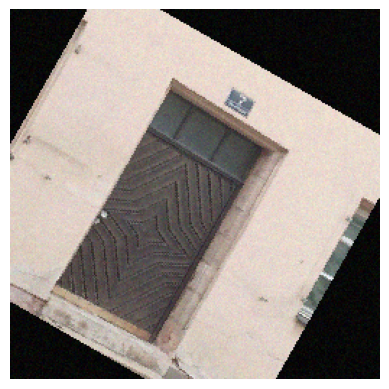

[0. 0. 0. 0. 0. 0. 1. 0. 0.]
5640
5640
1770
1770


In [ ]:
def plot_image(image_array):
  image_array = image_array.reshape((256, 256, 3))

  # Zeige das Bild an
  plt.imshow(image_array)
  plt.axis('off')  # Optionale Anweisung, um Achsen zu entfernen
  plt.show()

index = random.randint(0, data_augment_count * 470 - 1)
print(index)
plot_image(train_inputs[data_augment_count * 470-1])
print(train_labels[data_augment_count * 470-1])
print(len(train_inputs))
print(len(train_labels))
print(len(test_inputs))
print(len(test_labels))

In [ ]:
!zip -r /content/streetnumbers1.zip streetnumbers/ > /dev/null

In [ ]:
!cp /content/streetnumbers1.zip /content/drive/MyDrive/DataForNotebooks/

In [ ]:
with open('/content/StreetNumbers/StreetNumbers/sample_submission.csv', 'r') as file:
    # create a CSV reader object
    csv_reader = csv.reader(file)
     # skip the header row
    next(csv_reader, None)
    # get the second column using list comprehension
    column_1 = [int(row[0]) for row in csv_reader]

print(column_1)

[14, 17, 24, 27, 28, 30, 33, 34, 35, 36, 38, 39, 43, 46, 47, 49, 51, 60, 64, 70, 71, 74, 75, 77, 82, 86, 96, 97, 99, 105, 109, 115, 116, 124, 130, 146, 148, 151, 154, 155, 157, 159, 172, 179, 181, 186, 196, 221, 241, 247, 248, 251, 260, 270, 271, 273, 293, 298, 308, 309, 313, 317, 322, 332, 343, 348, 354, 355, 362, 365, 367, 380, 386, 392, 395, 396, 398, 406, 408, 409, 413, 414, 420, 421, 422, 426, 428, 431, 433, 434, 437, 439, 441, 446, 451, 454, 456, 458, 461, 468, 469, 481, 493, 495, 496, 511, 513, 518, 520, 521, 532, 533, 538, 558, 562, 565, 567, 571, 576, 584, 585, 587, 597, 599, 601, 604, 622, 629, 634, 636, 652, 655, 657, 665, 675, 684, 689, 693, 698, 701, 702, 709, 711, 712]
